In [100]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import matplotlib.pyplot as plt

---

In [12]:
# Инициализация датасета
df = pd.read_csv('./data/train.csv', parse_dates=['date'], index_col=['date'])

/var/folders/df/dz8wtw0j7791hg98mrx_thxc0000gn/T/ipykernel_9806/3065445199.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/train.csv', parse_dates=['date'], index_col=['date'])


In [90]:
df.rename(columns={'unit_sales':'sales'}, inplace=True)
display(df.head()) # Основная структура таблицы
print(f"Количество строк исходного датасета: {df.shape[0]}")

,id,store_nbr,item_nbr,sales,onpromotion
date,,,,,
2013-01-01,0,25,103665,7.0,NaN
2013-01-01,1,25,105574,1.0,NaN
2013-01-01,2,25,105575,2.0,NaN
2013-01-01,3,25,108079,1.0,NaN
2013-01-01,4,25,108701,1.0,NaN


Количество строк исходного датасета: 125497040


---

### Предподготовка данных

In [94]:
# Отфильтруем по 25 магазину и найдем сумму продаж
df_25 = df.query("store_nbr == 25")
df_25 = df_25.groupby(by=df_25.index)['sales'].sum()

# Зададим частоту равную дню и проведема интерполяцию для последующей декомпозиции
df_25 = df_25.asfreq(freq='D')
df_25 = df_25.interpolate(method='linear')
df_25 = pd.DataFrame(df_25)

display(df_25.head())
print(f"Пропуски: {df_25.isna().sum()}")

,sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


Пропуски: sales    0
dtype: int64


---

### Сезонное разложение ряда

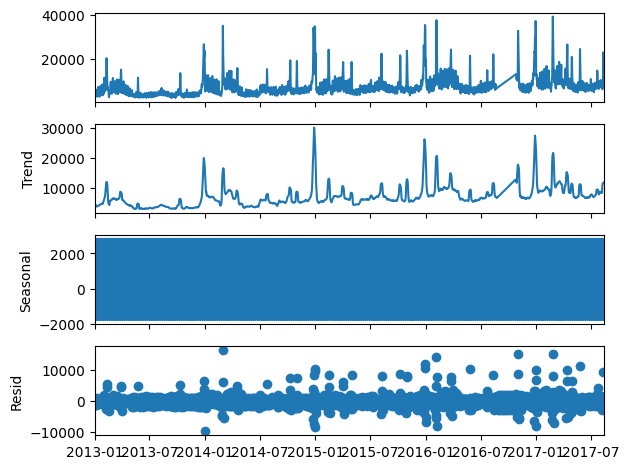

In [95]:
decomposition = seasonal_decompose(df_25) 
decomposition.plot();


---

### Ответы на вопросы модуля

In [96]:
seasonal = decomposition.seasonal
trend = decomposition.trend

residuals = decomposition.resid
#residuals = residuals.dropna()

print(f"Количество элементов в исходном датасете: {df.shape[0]}")
print(f"Количество элементов в шумовой части: {residuals.shape[0]}")
print(f"Количество числовых элементов в шумовой части: {residuals.dropna().shape[0]}")
print(f"Количество элементов в сезонной части: {seasonal.shape[0]}")
print(f"Количество элементов в трендовой части: {trend.shape[0]}")

Количество элементов в исходном датасете: 125497040
Количество элементов в шумовой части: 1688
Количество числовых элементов в шумовой части: 1682
Количество элементов в сезонной части: 1688
Количество элементов в трендовой части: 1688


In [98]:
# Тест на стационарность
test = adfuller(df_25['sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -5.001296622947661
p-value:  2.206239337839275e-05
Critical values:  {'1%': -3.4342906911169404, '5%': -2.8632805908715726, '10%': -2.5676966486957706}
ряд стационарен


---

### Формирование тренировочной и тестовой выборок

In [114]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

train_test_groups = tscv.split(df_25['sales']) 


for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 1667 TEST size: 7
TRAIN size: 1674 TEST size: 7
TRAIN size: 1681 TEST size: 7


In [115]:
train_test_groups = tscv.split(df_25['sales']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", (train_index), "TEST size:", (test_index))

TRAIN size: [   0    1    2 ... 1664 1665 1666] TEST size: [1667 1668 1669 1670 1671 1672 1673]
TRAIN size: [   0    1    2 ... 1671 1672 1673] TEST size: [1674 1675 1676 1677 1678 1679 1680]
TRAIN size: [   0    1    2 ... 1678 1679 1680] TEST size: [1681 1682 1683 1684 1685 1686 1687]
